In [ ]:
pip install GPUtil

**Training and Evaluation with 5-shots**

Epoch 1/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8076 - loss: 0.5616 - val_accuracy: 0.9124 - val_loss: 0.2633
Epoch 2/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9134 - loss: 0.2632 - val_accuracy: 0.9256 - val_loss: 0.2275
Epoch 3/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9263 - loss: 0.2295 - val_accuracy: 0.9245 - val_loss: 0.2460
Epoch 4/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9315 - loss: 0.2159 - val_accuracy: 0.9347 - val_loss: 0.2090
Epoch 5/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9351 - loss: 0.2049 - val_accuracy: 0.9342 - val_loss: 0.2118
Epoch 6/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9357 - loss: 0.1979 - val_accuracy: 0.9353 - val_loss: 0.2064
Epoch 7/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9374 - loss: 0.1909 - val_accuracy: 0.9390 - val_loss: 0.2020
Epoch 8/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9392 - loss: 0.1876 - val_accuracy: 0.

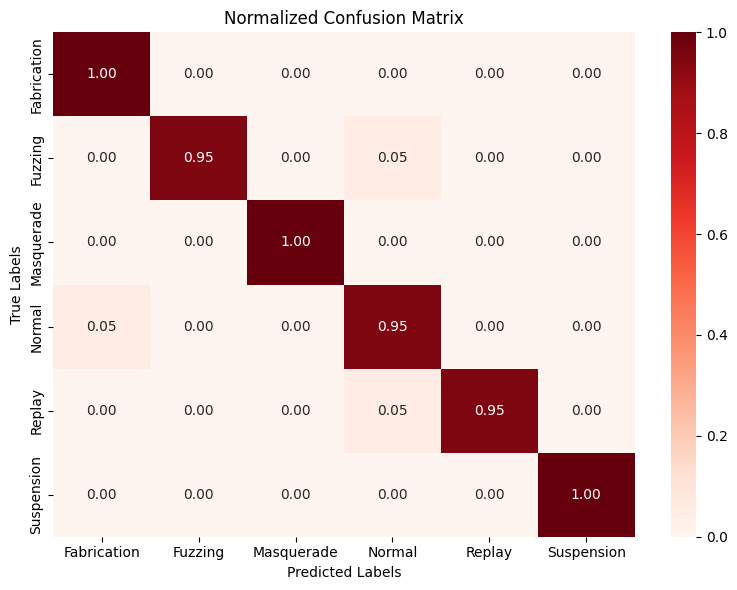

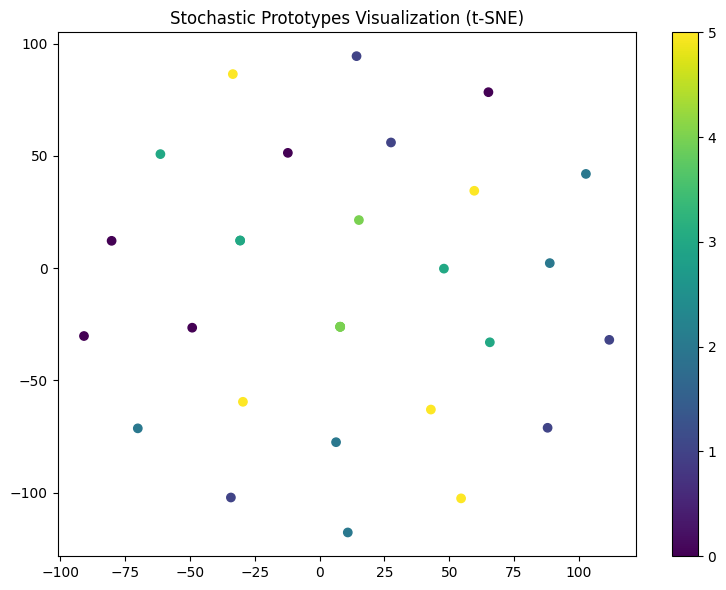

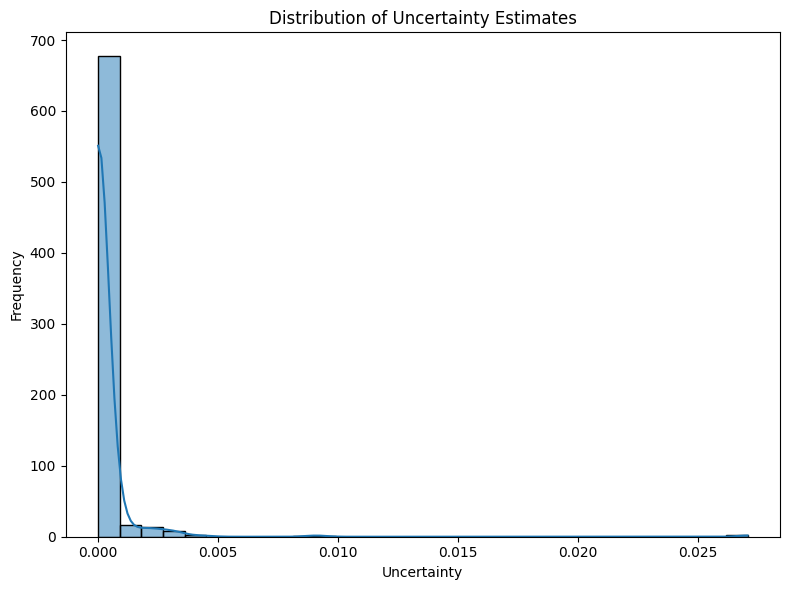

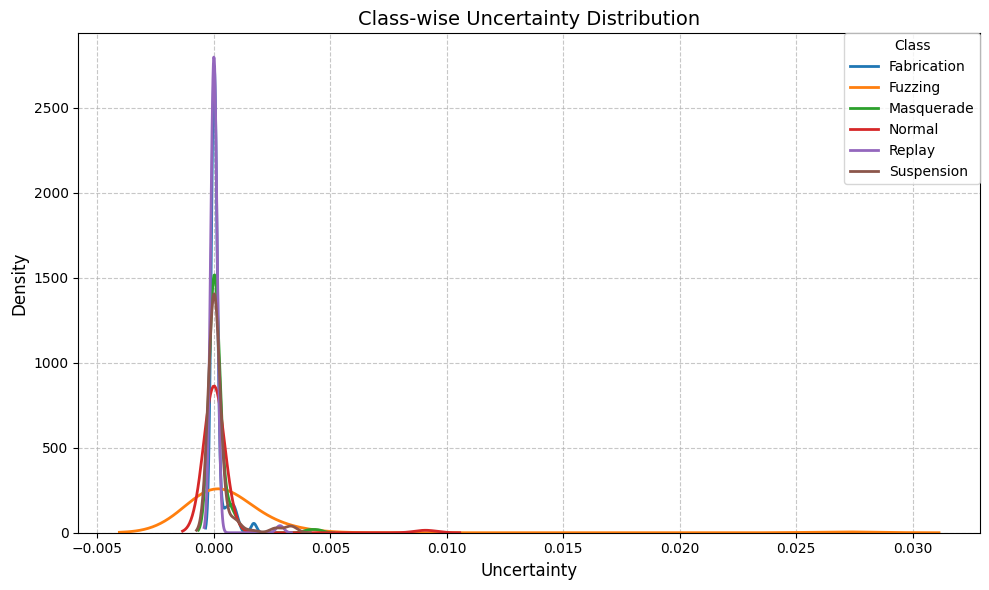

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


Inference Time: 0.8459 seconds
Model Size: 12.12 MB
Training Cost: 44.97 seconds


In [ ]:
# ================================
# Import Required Libraries
# ================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import time
import psutil
import GPUtil
import os
from scipy.stats import sem, t

# ================================
# Data Loading and Preprocessing
# ================================
def load_and_preprocess_data(filepath):
    # Load dataset
    df = pd.read_csv(filepath, low_memory=False)

    # Split features and labels
    X = df.drop(columns=["label"])
    y = df["label"]

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    class_names = label_encoder.classes_

    # One-hot encode categorical features
    X = pd.get_dummies(X, drop_first=True)
    X.fillna(X.median(), inplace=True)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Prepare labels for multi-class classification
    num_classes = len(class_names)
    y_one_hot = to_categorical(y_encoded, num_classes=num_classes)

    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, num_classes, class_names

# ================================
# Main Architecture
# ================================
class StochasticRandomNeuralNetworkLayer(Layer):
    def __init__(self, units, noise_stddev=0.05, **kwargs):
        super(StochasticRandomNeuralNetworkLayer, self).__init__(**kwargs)
        self.units = units
        self.noise_stddev = noise_stddev

    def build(self, input_shape):
        self.we = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='glorot_uniform',
                                  name='we')
        self.wi = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='glorot_uniform',
                                  name='wi')
        super(StochasticRandomNeuralNetworkLayer, self).build(input_shape)

    def call(self, inputs, training=False):
        excitatory = tf.matmul(inputs, self.we)
        inhibitory = tf.matmul(inputs, self.wi)
        potential = tf.nn.relu(excitatory - inhibitory)

        # Add Gaussian noise for stochasticity in prototype embedding
        if training:
            noise = tf.random.normal(shape=tf.shape(potential), mean=0.0, stddev=self.noise_stddev)
            potential += noise
        return potential

def build_stochastic_protonet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=(input_shape,))
    x = StochasticRandomNeuralNetworkLayer(512)(inputs)
    x = StochasticRandomNeuralNetworkLayer(256)(x)
    x = StochasticRandomNeuralNetworkLayer(128)(x)
    x = StochasticRandomNeuralNetworkLayer(64)(x)

    # Dropout for uncertainty estimation
    x = Dropout(0.2)(x, training=True)  # MC Dropout for stochastic sampling
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# ================================
# Training
# ================================
def train_model(model, X_train, y_train, epochs=20, batch_size=128, validation_split=0.2):
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training Time: {training_time:.2f} seconds")
    return history, training_time

# ================================
# Uncertainty Quantification
# ================================
def monte_carlo_predictions(model, X, n_samples=50):
    """
    Perform Monte Carlo dropout sampling to estimate uncertainty.
    Args:
        model: The trained model with dropout layers.
        X: Input data for prediction.
        n_samples: Number of stochastic forward passes.
    Returns:
        mean_prediction: Mean prediction across samples.
        uncertainty: Variance of predictions (uncertainty estimate).
    """
    predictions = []
    for _ in range(n_samples):
        # Enable dropout during inference
        pred = model(X, training=True)
        predictions.append(pred)

    # Stack predictions and compute mean and variance
    predictions = np.stack(predictions)
    mean_prediction = np.mean(predictions, axis=0)
    uncertainty = np.var(predictions, axis=0)

    return mean_prediction, uncertainty

def flag_ambiguous_cases(mean_prediction, uncertainty, threshold=0.1):
    """
    Flag predictions with high uncertainty for further analysis.
    Args:
        mean_prediction: Mean prediction across Monte Carlo samples.
        uncertainty: Variance of predictions (uncertainty estimate).
        threshold: Uncertainty threshold for flagging ambiguous cases.
    Returns:
        ambiguous_indices: Indices of samples with high uncertainty.
    """
    max_uncertainty = np.max(uncertainty, axis=1)  # Max uncertainty per sample
    ambiguous_indices = np.where(max_uncertainty > threshold)[0]
    return ambiguous_indices

# ================================
# Enhanced Stochastic Prototype Computation
# ================================
def compute_stochastic_prototypes(model, support_set, n_samples=50):
    """
    Compute stochastic prototypes by modeling their distribution.
    Args:
        model: The trained model.
        support_set: Support set data.
        n_samples: Number of samples to compute the distribution.
    Returns:
        mean_prototypes: Mean prototypes.
        prototype_uncertainty: Uncertainty of prototypes.
    """
    embeddings_list = []
    for _ in range(n_samples):
        embeddings_list.append(model(support_set, training=True))  # Enable dropout
    embeddings = np.stack(embeddings_list)

    # Compute mean and variance of prototypes
    mean_prototypes = np.mean(embeddings, axis=0)
    prototype_uncertainty = np.var(embeddings, axis=0)

    return mean_prototypes, prototype_uncertainty


# ================================
# Model Size Calculation
# ================================
def get_model_size(model):
    """
    Calculate the size of the model in MBs.
    Args:
        model: The trained model.
    Returns:
        size_mb: Size of the model in MBs.
    """
    model.save("temp_model.h5")
    size_mb = os.path.getsize("temp_model.h5") / (1024 * 1024)
    os.remove("temp_model.h5")
    return size_mb

# ================================
# Class-wise Uncertainty Visualization
# ================================
def plot_class_wise_uncertainty(query_uncertainty, query_true_classes, class_names):
    """
    Plot class-wise uncertainty distribution with clear class names.
    Args:
        query_uncertainty: Uncertainty estimates for the query set.
        query_true_classes: True class labels for the query set.
        class_names: List of class names.
    """
    plt.figure(figsize=(10, 6))
    for cls_idx, cls_name in enumerate(class_names):
        cls_uncertainty = query_uncertainty[query_true_classes == cls_idx].flatten()
        sns.kdeplot(cls_uncertainty, label=f'{cls_name}', linewidth=2)
    plt.title('Class-wise Uncertainty Distribution', fontsize=14)
    plt.xlabel('Uncertainty', fontsize=12)
    plt.ylabel('Density', fontsize=12)

    # Adjust the legend to be inside the main grid on the top right side
    plt.legend(title='Class', bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Save the plot as a high-resolution PNG with 1200 dpi
    plt.savefig('class_uncertainty_distribution(5-shots).png', dpi=1200, bbox_inches='tight')
    plt.show()

# ================================
# Few-Shot Training and Evaluation
# ================================
def few_shot_training_and_evaluation(model, X_train, y_train, X_test, y_test, n_shot=5, n_query=20, n_classes=6, class_names=None):
    """
    Perform few-shot training and evaluation with enhanced uncertainty quantification.
    """
    # Randomly select n_classes for few-shot learning
    selected_classes = np.random.choice(np.unique(np.argmax(y_train, axis=1)), n_classes, replace=False)

    # Create support and query sets
    support_set = []
    query_set = []
    query_indices = []  # To store query indices for true labels
    for cls in selected_classes:
        # Get indices of the current class
        cls_indices = np.where(np.argmax(y_train, axis=1) == cls)[0]

        # Randomly select n_shot support examples and n_query query examples
        support_indices = np.random.choice(cls_indices, n_shot, replace=False)
        query_indices_cls = np.random.choice(cls_indices, n_query, replace=False)

        # Add to support and query sets
        support_set.append(X_train[support_indices])
        query_set.append(X_train[query_indices_cls])
        query_indices.append(query_indices_cls)  # Store query indices for true labels

    # Stack support and query sets
    support_set = np.vstack(support_set)
    query_set = np.vstack(query_set)

    # Compute stochastic prototypes with uncertainty
    mean_prototypes, prototype_uncertainty = compute_stochastic_prototypes(model, support_set)

    # Predict on the query set with uncertainty quantification
    mean_predictions, query_uncertainty = monte_carlo_predictions(model, query_set, n_samples=50)
    query_pred_classes = np.argmax(mean_predictions, axis=1)

    # Flag ambiguous cases
    ambiguous_indices = flag_ambiguous_cases(mean_predictions, query_uncertainty, threshold=0.1)
    print(f"Ambiguous Cases (High Uncertainty): {len(ambiguous_indices)}")

    # True labels for the query set
    query_true_classes = np.argmax(y_train[np.concatenate(query_indices)], axis=1)

    # Calculate additional metrics
    accuracy = accuracy_score(query_true_classes, query_pred_classes)
    precision = precision_score(query_true_classes, query_pred_classes, average='weighted')
    recall = recall_score(query_true_classes, query_pred_classes, average='weighted')
    f1 = f1_score(query_true_classes, query_pred_classes, average='weighted')

    # Print metrics
    print(f"Few-Shot Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(query_true_classes, query_pred_classes, target_names=class_names))

    # Normalized Confusion Matrix
    conf_matrix = confusion_matrix(query_true_classes, query_pred_classes, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    # Save the plot as a high-resolution PNG with 1200 dpi
    plt.savefig('confusion_matrix(5-shots).png', dpi=1200, bbox_inches='tight')
    plt.show()

    # Visualize Stochastic Prototypes using t-SNE
    if len(mean_prototypes) > 1:  # Ensure there are enough samples for t-SNE
        perplexity_value = min(30, len(mean_prototypes) - 1)  # Adjust perplexity dynamically
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
        prototypes_2d = tsne.fit_transform(mean_prototypes)

        # Repeat class labels for each sample in the support set
        class_labels = np.repeat(selected_classes, n_shot)

        plt.figure(figsize=(8, 6))
        plt.scatter(prototypes_2d[:, 0], prototypes_2d[:, 1], c=class_labels, cmap='viridis', marker='o')
        plt.title('Stochastic Prototypes Visualization (t-SNE)')
        plt.colorbar()
        plt.tight_layout()
        # Save the plot as a high-resolution PNG with 1200 dpi
        plt.savefig('stochastic_visulaization(5-shots).png', dpi=1200, bbox_inches='tight')
        plt.show()
    else:
        print("Not enough samples to visualize prototypes using t-SNE.")

    # Visualize Uncertainty Estimates
    plt.figure(figsize=(8, 6))
    sns.histplot(query_uncertainty.flatten(), kde=True, bins=30)
    plt.title('Distribution of Uncertainty Estimates')
    plt.xlabel('Uncertainty')
    plt.ylabel('Frequency')
    plt.tight_layout()
    # Save the plot as a high-resolution PNG with 1200 dpi
    plt.savefig('distribution_uncertanity(5-shots).png', dpi=1200, bbox_inches='tight')
    plt.show()

    # Visualize Class-wise Uncertainty Distribution
    plot_class_wise_uncertainty(query_uncertainty, query_true_classes, class_names)



    # Measure Inference Time
    start_time = time.time()
    _ = model.predict(query_set)
    inference_time = time.time() - start_time
    print(f"Inference Time: {inference_time:.4f} seconds")

    # Measure Model Size
    model_size_mb = get_model_size(model)
    print(f"Model Size: {model_size_mb:.2f} MB")

    return mean_predictions, query_uncertainty, ambiguous_indices

# ================================
# Memory and CPU/GPU Usage
# ================================
def get_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)  # in MBs

def get_gpu_usage():
    gpus = GPUtil.getGPUs()
    if len(gpus) > 0:
        return gpus[0].memoryUsed  # in MBs
    return 0

# ================================
# Main Execution
# ================================
if __name__ == "__main__":
    # Load and preprocess data
    filepath = '/content/drive/MyDrive/Vehicle Malware Dataset/CSV Files/IoV_reduced_data.csv'
    X_train, X_test, y_train, y_test, num_classes, class_names = load_and_preprocess_data(filepath)

    # Build and compile the model
    input_shape = X_train.shape[1]
    model = build_stochastic_protonet(input_shape, num_classes)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Measure memory usage before training
    memory_before = get_memory_usage()
    gpu_memory_before = get_gpu_usage()

    # Train the model
    history, training_time = train_model(model, X_train, y_train)

    # Measure memory usage after training
    memory_after = get_memory_usage()
    gpu_memory_after = get_gpu_usage()

    # Print memory usage
    print(f"Memory Usage Before Training: {memory_before:.2f} MB")
    print(f"Memory Usage After Training: {memory_after:.2f} MB")
    print(f"GPU Memory Usage Before Training: {gpu_memory_before:.2f} MB")
    print(f"GPU Memory Usage After Training: {gpu_memory_after:.2f} MB")

    # Few-shot training and evaluation
    mean_predictions, query_uncertainty, ambiguous_indices = few_shot_training_and_evaluation(
        model, X_train, y_train, X_test, y_test, n_shot=5, n_query=20, n_classes=6, class_names=class_names
    )

    # Print training cost and inference time
    print(f"Training Cost: {training_time:.2f} seconds")

**2. Training and Evaluation with 10-shots**

Epoch 1/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8114 - loss: 0.5284 - val_accuracy: 0.9042 - val_loss: 0.2733
Epoch 2/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9130 - loss: 0.2638 - val_accuracy: 0.9258 - val_loss: 0.2329
Epoch 3/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9262 - loss: 0.2303 - val_accuracy: 0.9318 - val_loss: 0.2192
Epoch 4/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9315 - loss: 0.2194 - val_accuracy: 0.9323 - val_loss: 0.2118
Epoch 5/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9350 - loss: 0.2060 - val_accuracy: 0.9360 - val_loss: 0.2150
Epoch 6/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9373 - loss: 0.1974 - val_accuracy: 0.9342 - val_loss: 0.2381
Epoch 7/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9382 - loss: 0.1893 - val_accuracy: 0.9349 - val_loss: 0.2164
Epoch 8/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9392 - loss: 0.1857 - val_accuracy: 0.

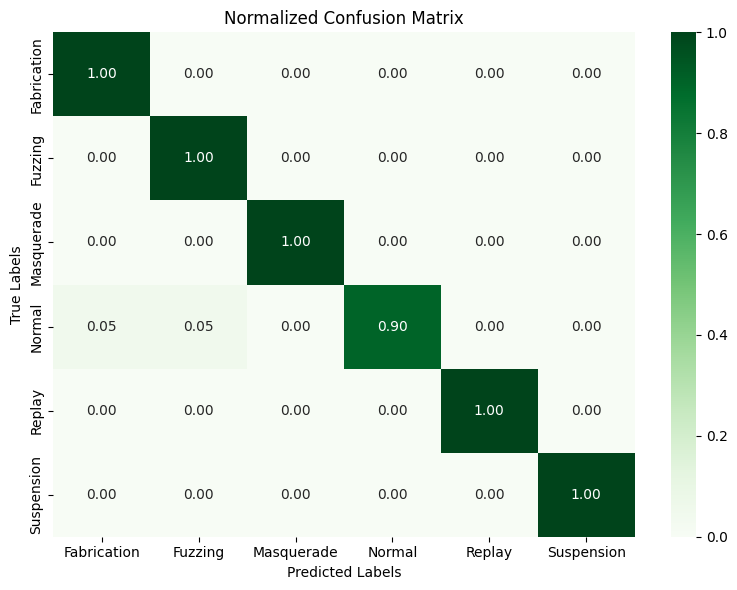

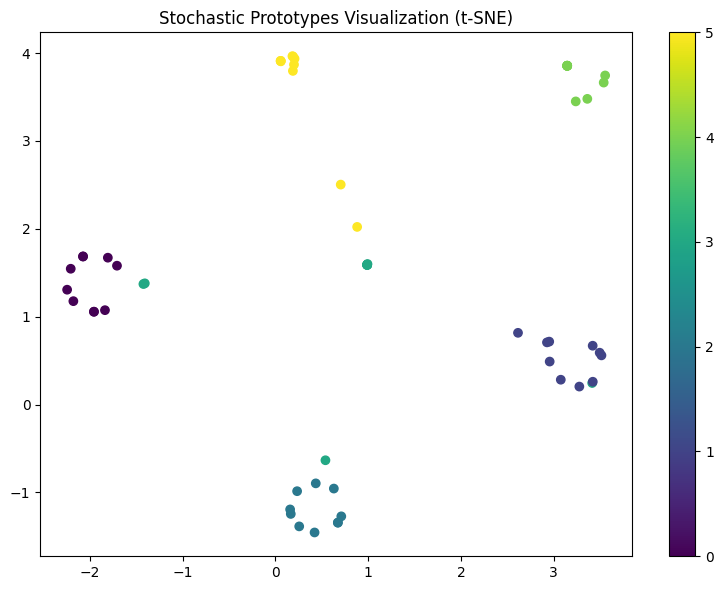

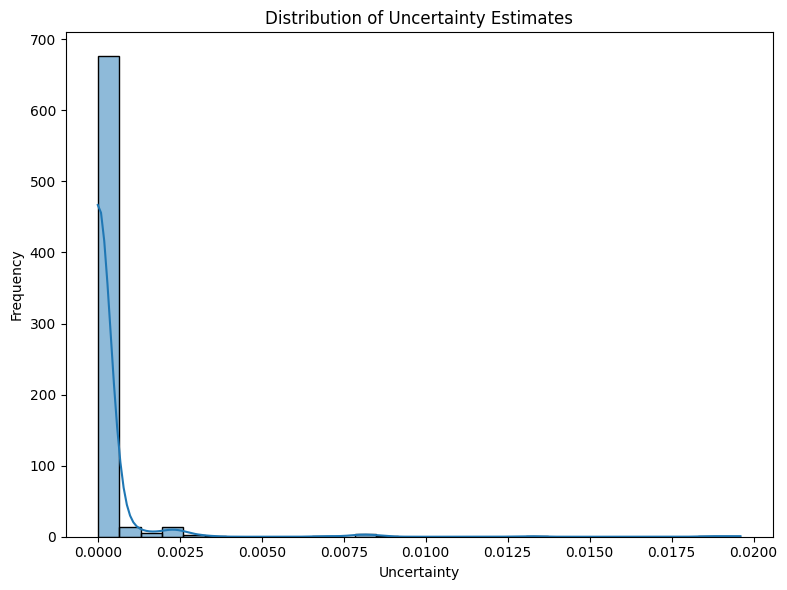

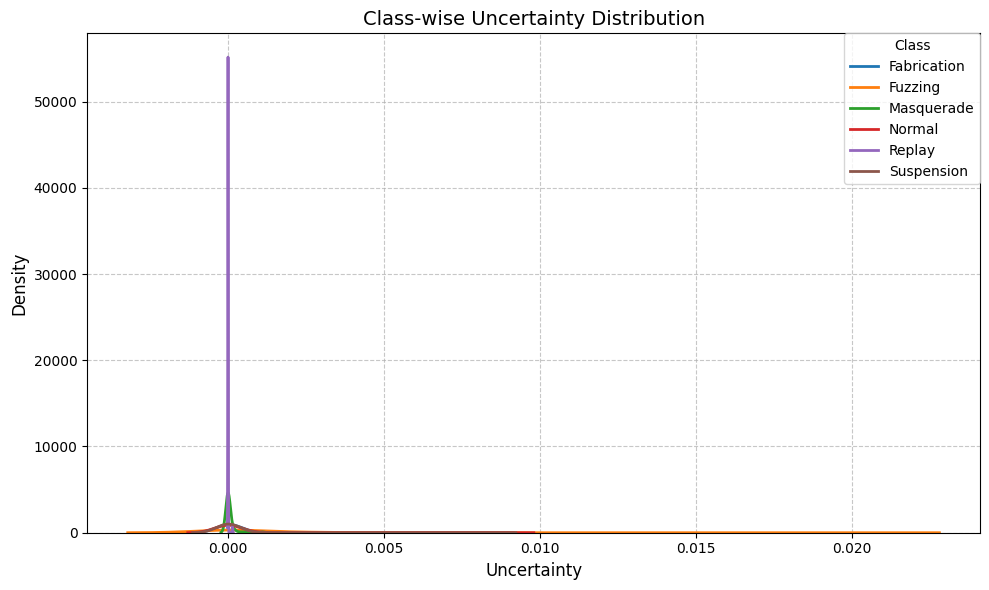

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Inference Time: 0.8773 seconds
Model Size: 12.12 MB
Training Cost: 44.36 seconds


In [ ]:
# ================================
# Import Required Libraries
# ================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import time
import psutil
import GPUtil
import os
from scipy.stats import sem, t

# ================================
# Data Loading and Preprocessing
# ================================
def load_and_preprocess_data(filepath):
    # Load dataset
    df = pd.read_csv(filepath, low_memory=False)

    # Split features and labels
    X = df.drop(columns=["label"])
    y = df["label"]

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    class_names = label_encoder.classes_

    # One-hot encode categorical features
    X = pd.get_dummies(X, drop_first=True)
    X.fillna(X.median(), inplace=True)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Prepare labels for multi-class classification
    num_classes = len(class_names)
    y_one_hot = to_categorical(y_encoded, num_classes=num_classes)

    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, num_classes, class_names

# ================================
# Main Architecture
# ================================
class StochasticRandomNeuralNetworkLayer(Layer):
    def __init__(self, units, noise_stddev=0.05, **kwargs):
        super(StochasticRandomNeuralNetworkLayer, self).__init__(**kwargs)
        self.units = units
        self.noise_stddev = noise_stddev

    def build(self, input_shape):
        self.we = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='glorot_uniform',
                                  name='we')
        self.wi = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='glorot_uniform',
                                  name='wi')
        super(StochasticRandomNeuralNetworkLayer, self).build(input_shape)

    def call(self, inputs, training=False):
        excitatory = tf.matmul(inputs, self.we)
        inhibitory = tf.matmul(inputs, self.wi)
        potential = tf.nn.relu(excitatory - inhibitory)

        # Add Gaussian noise for stochasticity in prototype embedding
        if training:
            noise = tf.random.normal(shape=tf.shape(potential), mean=0.0, stddev=self.noise_stddev)
            potential += noise
        return potential

def build_stochastic_protonet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=(input_shape,))
    x = StochasticRandomNeuralNetworkLayer(512)(inputs)
    x = StochasticRandomNeuralNetworkLayer(256)(x)
    x = StochasticRandomNeuralNetworkLayer(128)(x)
    x = StochasticRandomNeuralNetworkLayer(64)(x)

    # Dropout for uncertainty estimation
    x = Dropout(0.2)(x, training=True)  # MC Dropout for stochastic sampling
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# ================================
# Training
# ================================
def train_model(model, X_train, y_train, epochs=20, batch_size=128, validation_split=0.2):
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training Time: {training_time:.2f} seconds")
    return history, training_time

# ================================
# Uncertainty Quantification
# ================================
def monte_carlo_predictions(model, X, n_samples=50):
    """
    Perform Monte Carlo dropout sampling to estimate uncertainty.
    Args:
        model: The trained model with dropout layers.
        X: Input data for prediction.
        n_samples: Number of stochastic forward passes.
    Returns:
        mean_prediction: Mean prediction across samples.
        uncertainty: Variance of predictions (uncertainty estimate).
    """
    predictions = []
    for _ in range(n_samples):
        # Enable dropout during inference
        pred = model(X, training=True)
        predictions.append(pred)

    # Stack predictions and compute mean and variance
    predictions = np.stack(predictions)
    mean_prediction = np.mean(predictions, axis=0)
    uncertainty = np.var(predictions, axis=0)

    return mean_prediction, uncertainty

def flag_ambiguous_cases(mean_prediction, uncertainty, threshold=0.01):
    """
    Flag predictions with high uncertainty for further analysis.
    Args:
        mean_prediction: Mean prediction across Monte Carlo samples.
        uncertainty: Variance of predictions (uncertainty estimate).
        threshold: Uncertainty threshold for flagging ambiguous cases.
    Returns:
        ambiguous_indices: Indices of samples with high uncertainty.
    """
    max_uncertainty = np.max(uncertainty, axis=1)  # Max uncertainty per sample
    ambiguous_indices = np.where(max_uncertainty > threshold)[0]
    return ambiguous_indices

# ================================
# Enhanced Stochastic Prototype Computation
# ================================
def compute_stochastic_prototypes(model, support_set, n_samples=50):
    """
    Compute stochastic prototypes by modeling their distribution.
    Args:
        model: The trained model.
        support_set: Support set data.
        n_samples: Number of samples to compute the distribution.
    Returns:
        mean_prototypes: Mean prototypes.
        prototype_uncertainty: Uncertainty of prototypes.
    """
    embeddings_list = []
    for _ in range(n_samples):
        embeddings_list.append(model(support_set, training=True))  # Enable dropout
    embeddings = np.stack(embeddings_list)

    # Compute mean and variance of prototypes
    mean_prototypes = np.mean(embeddings, axis=0)
    prototype_uncertainty = np.var(embeddings, axis=0)

    return mean_prototypes, prototype_uncertainty


# ================================
# Model Size Calculation
# ================================
def get_model_size(model):
    """
    Calculate the size of the model in MBs.
    Args:
        model: The trained model.
    Returns:
        size_mb: Size of the model in MBs.
    """
    model.save("temp_model.h5")
    size_mb = os.path.getsize("temp_model.h5") / (1024 * 1024)
    os.remove("temp_model.h5")
    return size_mb

# ================================
# Class-wise Uncertainty Visualization
# ================================
def plot_class_wise_uncertainty(query_uncertainty, query_true_classes, class_names):
    """
    Plot class-wise uncertainty distribution with clear class names.
    Args:
        query_uncertainty: Uncertainty estimates for the query set.
        query_true_classes: True class labels for the query set.
        class_names: List of class names.
    """
    plt.figure(figsize=(10, 6))
    for cls_idx, cls_name in enumerate(class_names):
        cls_uncertainty = query_uncertainty[query_true_classes == cls_idx].flatten()
        sns.kdeplot(cls_uncertainty, label=f'{cls_name}', linewidth=2)
    plt.title('Class-wise Uncertainty Distribution', fontsize=14)
    plt.xlabel('Uncertainty', fontsize=12)
    plt.ylabel('Density', fontsize=12)

    # Adjust the legend to be inside the main grid on the top right side
    plt.legend(title='Class', bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Save the plot as a high-resolution PNG with 1200 dpi
    plt.savefig('class_uncertainty_distribution(10-shots).png', dpi=1200, bbox_inches='tight')
    plt.show()

# ================================
# Few-Shot Training and Evaluation
# ================================
def few_shot_training_and_evaluation(model, X_train, y_train, X_test, y_test, n_shot=10, n_query=20, n_classes=6, class_names=None):
    """
    Perform few-shot training and evaluation with enhanced uncertainty quantification.
    """
    # Randomly select n_classes for few-shot learning
    selected_classes = np.random.choice(np.unique(np.argmax(y_train, axis=1)), n_classes, replace=False)

    # Create support and query sets
    support_set = []
    query_set = []
    query_indices = []  # To store query indices for true labels
    for cls in selected_classes:
        # Get indices of the current class
        cls_indices = np.where(np.argmax(y_train, axis=1) == cls)[0]

        # Randomly select n_shot support examples and n_query query examples
        support_indices = np.random.choice(cls_indices, n_shot, replace=False)
        query_indices_cls = np.random.choice(cls_indices, n_query, replace=False)

        # Add to support and query sets
        support_set.append(X_train[support_indices])
        query_set.append(X_train[query_indices_cls])
        query_indices.append(query_indices_cls)  # Store query indices for true labels

    # Stack support and query sets
    support_set = np.vstack(support_set)
    query_set = np.vstack(query_set)

    # Compute stochastic prototypes with uncertainty
    mean_prototypes, prototype_uncertainty = compute_stochastic_prototypes(model, support_set)

    # Predict on the query set with uncertainty quantification
    mean_predictions, query_uncertainty = monte_carlo_predictions(model, query_set, n_samples=50)
    query_pred_classes = np.argmax(mean_predictions, axis=1)

    # Flag ambiguous cases
    ambiguous_indices = flag_ambiguous_cases(mean_predictions, query_uncertainty, threshold=0.01)
    print(f"Ambiguous Cases (High Uncertainty): {len(ambiguous_indices)}")

    # True labels for the query set
    query_true_classes = np.argmax(y_train[np.concatenate(query_indices)], axis=1)

    # Calculate additional metrics
    accuracy = accuracy_score(query_true_classes, query_pred_classes)
    precision = precision_score(query_true_classes, query_pred_classes, average='weighted')
    recall = recall_score(query_true_classes, query_pred_classes, average='weighted')
    f1 = f1_score(query_true_classes, query_pred_classes, average='weighted')

    # Print metrics
    print(f"Few-Shot Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(query_true_classes, query_pred_classes, target_names=class_names))

    # Normalized Confusion Matrix
    conf_matrix = confusion_matrix(query_true_classes, query_pred_classes, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    # Save the plot as a high-resolution PNG with 1200 dpi
    plt.savefig('confusion_matrix(10-shots).png', dpi=1200, bbox_inches='tight')
    plt.show()

    # Visualize Stochastic Prototypes using t-SNE
    if len(mean_prototypes) > 1:  # Ensure there are enough samples for t-SNE
        perplexity_value = min(30, len(mean_prototypes) - 1)  # Adjust perplexity dynamically
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
        prototypes_2d = tsne.fit_transform(mean_prototypes)

        # Repeat class labels for each sample in the support set
        class_labels = np.repeat(selected_classes, n_shot)

        plt.figure(figsize=(8, 6))
        plt.scatter(prototypes_2d[:, 0], prototypes_2d[:, 1], c=class_labels, cmap='viridis', marker='o')
        plt.title('Stochastic Prototypes Visualization (t-SNE)')
        plt.colorbar()
        plt.tight_layout()
        # Save the plot as a high-resolution PNG with 1200 dpi
        plt.savefig('stochastic_visulaization(10-shots).png', dpi=1200, bbox_inches='tight')
        plt.show()
    else:
        print("Not enough samples to visualize prototypes using t-SNE.")

    # Visualize Uncertainty Estimates
    plt.figure(figsize=(8, 6))
    sns.histplot(query_uncertainty.flatten(), kde=True, bins=30)
    plt.title('Distribution of Uncertainty Estimates')
    plt.xlabel('Uncertainty')
    plt.ylabel('Frequency')
    plt.tight_layout()
    # Save the plot as a high-resolution PNG with 1200 dpi
    plt.savefig('distribution_uncertanity(10-shots).png', dpi=1200, bbox_inches='tight')
    plt.show()

    # Visualize Class-wise Uncertainty Distribution
    plot_class_wise_uncertainty(query_uncertainty, query_true_classes, class_names)



    # Measure Inference Time
    start_time = time.time()
    _ = model.predict(query_set)
    inference_time = time.time() - start_time
    print(f"Inference Time: {inference_time:.4f} seconds")

    # Measure Model Size
    model_size_mb = get_model_size(model)
    print(f"Model Size: {model_size_mb:.2f} MB")

    return mean_predictions, query_uncertainty, ambiguous_indices

# ================================
# Memory and CPU/GPU Usage
# ================================
def get_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)  # in MBs

def get_gpu_usage():
    gpus = GPUtil.getGPUs()
    if len(gpus) > 0:
        return gpus[0].memoryUsed  # in MBs
    return 0

# ================================
# Main Execution
# ================================
if __name__ == "__main__":
    # Load and preprocess data
    filepath = '/content/drive/MyDrive/Vehicle Malware Dataset/CSV Files/IoV_reduced_data.csv'
    X_train, X_test, y_train, y_test, num_classes, class_names = load_and_preprocess_data(filepath)

    # Build and compile the model
    input_shape = X_train.shape[1]
    model = build_stochastic_protonet(input_shape, num_classes)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Measure memory usage before training
    memory_before = get_memory_usage()
    gpu_memory_before = get_gpu_usage()

    # Train the model
    history, training_time = train_model(model, X_train, y_train)

    # Measure memory usage after training
    memory_after = get_memory_usage()
    gpu_memory_after = get_gpu_usage()

    # Print memory usage
    print(f"Memory Usage Before Training: {memory_before:.2f} MB")
    print(f"Memory Usage After Training: {memory_after:.2f} MB")
    print(f"GPU Memory Usage Before Training: {gpu_memory_before:.2f} MB")
    print(f"GPU Memory Usage After Training: {gpu_memory_after:.2f} MB")

    # Few-shot training and evaluation
    mean_predictions, query_uncertainty, ambiguous_indices = few_shot_training_and_evaluation(
        model, X_train, y_train, X_test, y_test, n_shot=10, n_query=20, n_classes=6, class_names=class_names
    )

    # Print training cost and inference time
    print(f"Training Cost: {training_time:.2f} seconds")

**3. Training and Evaluation with 15-shots**

Epoch 1/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8131 - loss: 0.5264 - val_accuracy: 0.9099 - val_loss: 0.2663
Epoch 2/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9128 - loss: 0.2625 - val_accuracy: 0.9278 - val_loss: 0.2277
Epoch 3/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9257 - loss: 0.2314 - val_accuracy: 0.9249 - val_loss: 0.2371
Epoch 4/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9309 - loss: 0.2164 - val_accuracy: 0.9316 - val_loss: 0.2266
Epoch 5/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9341 - loss: 0.2054 - val_accuracy: 0.9343 - val_loss: 0.2095
Epoch 6/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9350 - loss: 0.2012 - val_accuracy: 0.9367 - val_loss: 0.2132
Epoch 7/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9373 - loss: 0.1931 - val_accuracy: 0.9362 - val_loss: 0.2080
Epoch 8/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9411 - loss: 0.1826 - val_accuracy: 0.

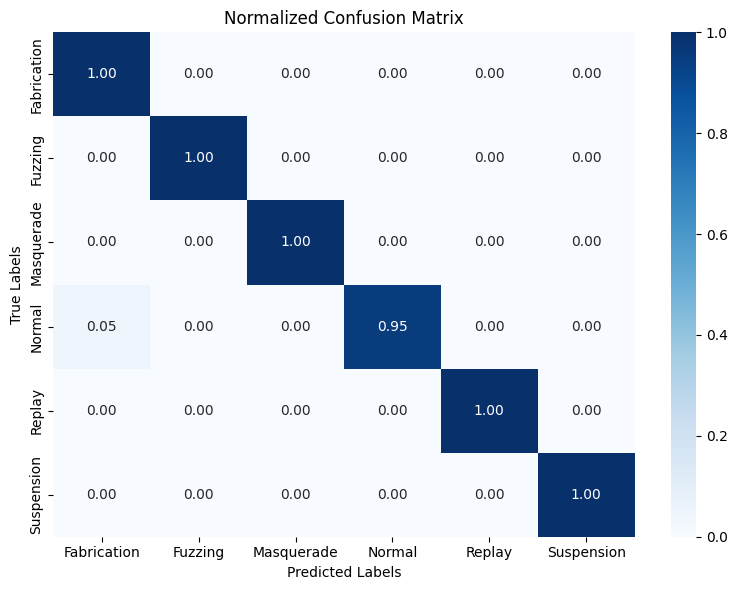

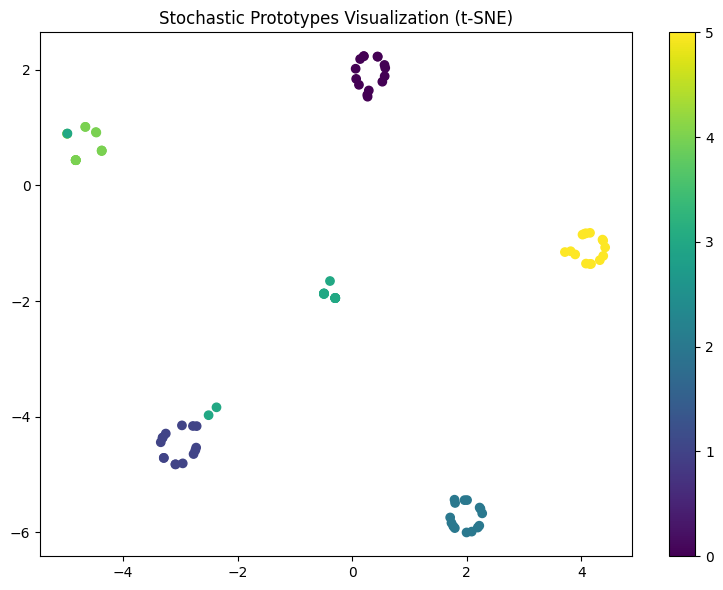

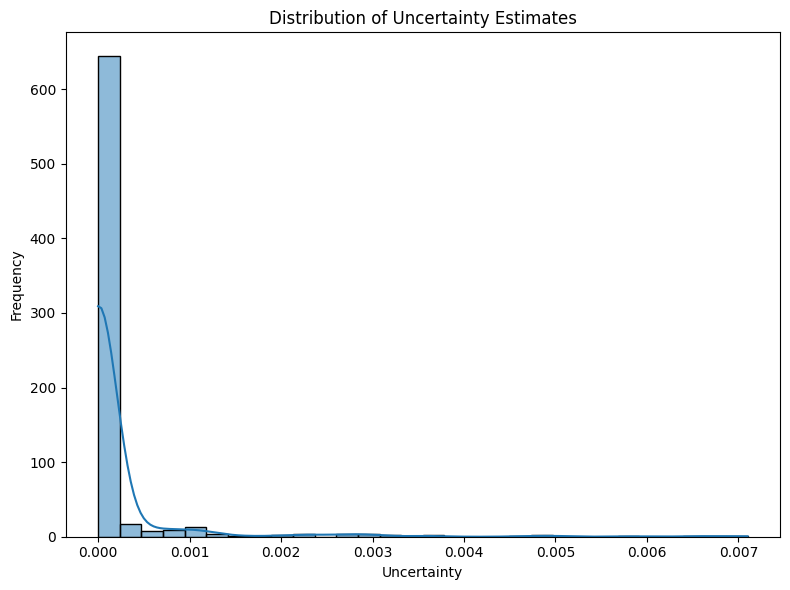

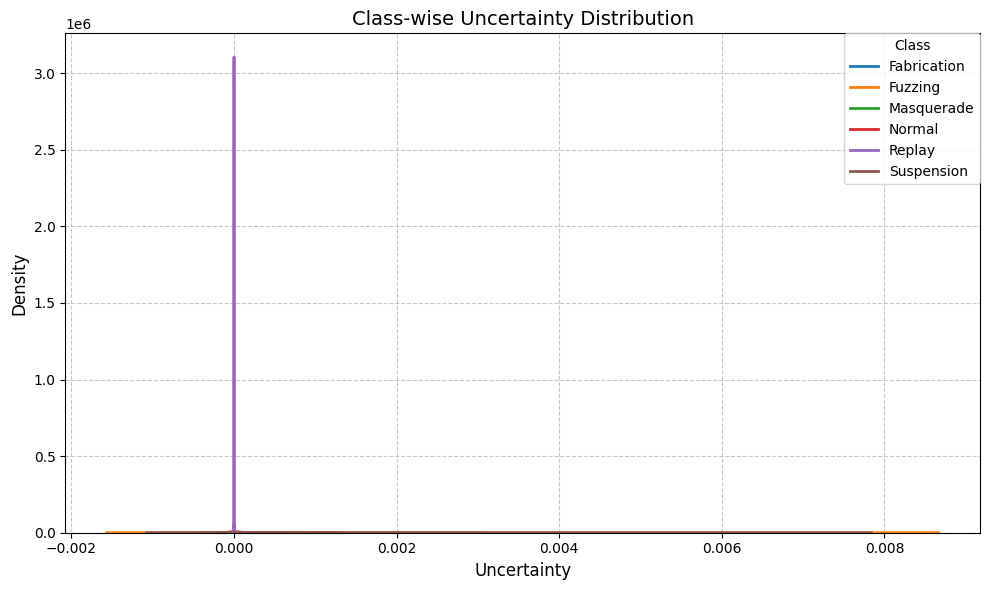

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Inference Time: 0.8451 seconds
Model Size: 12.12 MB
Training Cost: 45.91 seconds


In [ ]:
# ================================
# Import Required Libraries
# ================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import time
import psutil
import GPUtil
import os
from scipy.stats import sem, t

# ================================
# Data Loading and Preprocessing
# ================================
def load_and_preprocess_data(filepath):
    # Load dataset
    df = pd.read_csv(filepath, low_memory=False)

    # Split features and labels
    X = df.drop(columns=["label"])
    y = df["label"]

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    class_names = label_encoder.classes_

    # One-hot encode categorical features
    X = pd.get_dummies(X, drop_first=True)
    X.fillna(X.median(), inplace=True)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Prepare labels for multi-class classification
    num_classes = len(class_names)
    y_one_hot = to_categorical(y_encoded, num_classes=num_classes)

    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, num_classes, class_names

# ================================
# Main Architecture
# ================================
class StochasticRandomNeuralNetworkLayer(Layer):
    def __init__(self, units, noise_stddev=0.05, **kwargs):
        super(StochasticRandomNeuralNetworkLayer, self).__init__(**kwargs)
        self.units = units
        self.noise_stddev = noise_stddev

    def build(self, input_shape):
        self.we = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='glorot_uniform',
                                  name='we')
        self.wi = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='glorot_uniform',
                                  name='wi')
        super(StochasticRandomNeuralNetworkLayer, self).build(input_shape)

    def call(self, inputs, training=False):
        excitatory = tf.matmul(inputs, self.we)
        inhibitory = tf.matmul(inputs, self.wi)
        potential = tf.nn.relu(excitatory - inhibitory)

        # Add Gaussian noise for stochasticity in prototype embedding
        if training:
            noise = tf.random.normal(shape=tf.shape(potential), mean=0.0, stddev=self.noise_stddev)
            potential += noise
        return potential

def build_stochastic_protonet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=(input_shape,))
    x = StochasticRandomNeuralNetworkLayer(512)(inputs)
    x = StochasticRandomNeuralNetworkLayer(256)(x)
    x = StochasticRandomNeuralNetworkLayer(128)(x)
    x = StochasticRandomNeuralNetworkLayer(64)(x)

    # Dropout for uncertainty estimation
    x = Dropout(0.2)(x, training=True)  # MC Dropout for stochastic sampling
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# ================================
# Training
# ================================
def train_model(model, X_train, y_train, epochs=20, batch_size=128, validation_split=0.2):
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training Time: {training_time:.2f} seconds")
    return history, training_time

# ================================
# Uncertainty Quantification
# ================================
def monte_carlo_predictions(model, X, n_samples=50):
    """
    Perform Monte Carlo dropout sampling to estimate uncertainty.
    Args:
        model: The trained model with dropout layers.
        X: Input data for prediction.
        n_samples: Number of stochastic forward passes.
    Returns:
        mean_prediction: Mean prediction across samples.
        uncertainty: Variance of predictions (uncertainty estimate).
    """
    predictions = []
    for _ in range(n_samples):
        # Enable dropout during inference
        pred = model(X, training=True)
        predictions.append(pred)

    # Stack predictions and compute mean and variance
    predictions = np.stack(predictions)
    mean_prediction = np.mean(predictions, axis=0)
    uncertainty = np.var(predictions, axis=0)

    return mean_prediction, uncertainty

def flag_ambiguous_cases(mean_prediction, uncertainty, threshold=0.01):
    """
    Flag predictions with high uncertainty for further analysis.
    Args:
        mean_prediction: Mean prediction across Monte Carlo samples.
        uncertainty: Variance of predictions (uncertainty estimate).
        threshold: Uncertainty threshold for flagging ambiguous cases.
    Returns:
        ambiguous_indices: Indices of samples with high uncertainty.
    """
    max_uncertainty = np.max(uncertainty, axis=1)  # Max uncertainty per sample
    ambiguous_indices = np.where(max_uncertainty > threshold)[0]
    return ambiguous_indices

# ================================
# Enhanced Stochastic Prototype Computation
# ================================
def compute_stochastic_prototypes(model, support_set, n_samples=50):
    """
    Compute stochastic prototypes by modeling their distribution.
    Args:
        model: The trained model.
        support_set: Support set data.
        n_samples: Number of samples to compute the distribution.
    Returns:
        mean_prototypes: Mean prototypes.
        prototype_uncertainty: Uncertainty of prototypes.
    """
    embeddings_list = []
    for _ in range(n_samples):
        embeddings_list.append(model(support_set, training=True))  # Enable dropout
    embeddings = np.stack(embeddings_list)

    # Compute mean and variance of prototypes
    mean_prototypes = np.mean(embeddings, axis=0)
    prototype_uncertainty = np.var(embeddings, axis=0)

    return mean_prototypes, prototype_uncertainty


# ================================
# Model Size Calculation
# ================================
def get_model_size(model):
    """
    Calculate the size of the model in MBs.
    Args:
        model: The trained model.
    Returns:
        size_mb: Size of the model in MBs.
    """
    model.save("temp_model.h5")
    size_mb = os.path.getsize("temp_model.h5") / (1024 * 1024)
    os.remove("temp_model.h5")
    return size_mb

# ================================
# Class-wise Uncertainty Visualization
# ================================
def plot_class_wise_uncertainty(query_uncertainty, query_true_classes, class_names):
    """
    Plot class-wise uncertainty distribution with clear class names.
    Args:
        query_uncertainty: Uncertainty estimates for the query set.
        query_true_classes: True class labels for the query set.
        class_names: List of class names.
    """
    plt.figure(figsize=(10, 6))
    for cls_idx, cls_name in enumerate(class_names):
        cls_uncertainty = query_uncertainty[query_true_classes == cls_idx].flatten()
        sns.kdeplot(cls_uncertainty, label=f'{cls_name}', linewidth=2)
    plt.title('Class-wise Uncertainty Distribution', fontsize=14)
    plt.xlabel('Uncertainty', fontsize=12)
    plt.ylabel('Density', fontsize=12)

    # Adjust the legend to be inside the main grid on the top right side
    plt.legend(title='Class', bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Save the plot as a high-resolution PNG with 1200 dpi
    plt.savefig('class_uncertainty_distribution(15-shots).png', dpi=1200, bbox_inches='tight')
    plt.show()

# ================================
# Few-Shot Training and Evaluation
# ================================
def few_shot_training_and_evaluation(model, X_train, y_train, X_test, y_test, n_shot=15, n_query=20, n_classes=6, class_names=None):
    """
    Perform few-shot training and evaluation with enhanced uncertainty quantification.
    """
    # Randomly select n_classes for few-shot learning
    selected_classes = np.random.choice(np.unique(np.argmax(y_train, axis=1)), n_classes, replace=False)

    # Create support and query sets
    support_set = []
    query_set = []
    query_indices = []  # To store query indices for true labels
    for cls in selected_classes:
        # Get indices of the current class
        cls_indices = np.where(np.argmax(y_train, axis=1) == cls)[0]

        # Randomly select n_shot support examples and n_query query examples
        support_indices = np.random.choice(cls_indices, n_shot, replace=False)
        query_indices_cls = np.random.choice(cls_indices, n_query, replace=False)

        # Add to support and query sets
        support_set.append(X_train[support_indices])
        query_set.append(X_train[query_indices_cls])
        query_indices.append(query_indices_cls)  # Store query indices for true labels

    # Stack support and query sets
    support_set = np.vstack(support_set)
    query_set = np.vstack(query_set)

    # Compute stochastic prototypes with uncertainty
    mean_prototypes, prototype_uncertainty = compute_stochastic_prototypes(model, support_set)

    # Predict on the query set with uncertainty quantification
    mean_predictions, query_uncertainty = monte_carlo_predictions(model, query_set, n_samples=50)
    query_pred_classes = np.argmax(mean_predictions, axis=1)

    # Flag ambiguous cases
    ambiguous_indices = flag_ambiguous_cases(mean_predictions, query_uncertainty, threshold=0.01)
    print(f"Ambiguous Cases (High Uncertainty): {len(ambiguous_indices)}")

    # True labels for the query set
    query_true_classes = np.argmax(y_train[np.concatenate(query_indices)], axis=1)

    # Calculate additional metrics
    accuracy = accuracy_score(query_true_classes, query_pred_classes)
    precision = precision_score(query_true_classes, query_pred_classes, average='weighted')
    recall = recall_score(query_true_classes, query_pred_classes, average='weighted')
    f1 = f1_score(query_true_classes, query_pred_classes, average='weighted')

    # Print metrics
    print(f"Few-Shot Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(query_true_classes, query_pred_classes, target_names=class_names))

    # Normalized Confusion Matrix
    conf_matrix = confusion_matrix(query_true_classes, query_pred_classes, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    # Save the plot as a high-resolution PNG with 1200 dpi
    plt.savefig('confusion_matrix(15-shots).png', dpi=1200, bbox_inches='tight')
    plt.show()

    # Visualize Stochastic Prototypes using t-SNE
    if len(mean_prototypes) > 1:  # Ensure there are enough samples for t-SNE
        perplexity_value = min(30, len(mean_prototypes) - 1)  # Adjust perplexity dynamically
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
        prototypes_2d = tsne.fit_transform(mean_prototypes)

        # Repeat class labels for each sample in the support set
        class_labels = np.repeat(selected_classes, n_shot)

        plt.figure(figsize=(8, 6))
        plt.scatter(prototypes_2d[:, 0], prototypes_2d[:, 1], c=class_labels, cmap='viridis', marker='o')
        plt.title('Stochastic Prototypes Visualization (t-SNE)')
        plt.colorbar()
        plt.tight_layout()
        # Save the plot as a high-resolution PNG with 1200 dpi
        plt.savefig('stochastic_visulaization(15-shots).png', dpi=1200, bbox_inches='tight')
        plt.show()
    else:
        print("Not enough samples to visualize prototypes using t-SNE.")

    # Visualize Uncertainty Estimates
    plt.figure(figsize=(8, 6))
    sns.histplot(query_uncertainty.flatten(), kde=True, bins=30)
    plt.title('Distribution of Uncertainty Estimates')
    plt.xlabel('Uncertainty')
    plt.ylabel('Frequency')
    plt.tight_layout()
    # Save the plot as a high-resolution PNG with 1200 dpi
    plt.savefig('distribution_uncertanity(15-shots).png', dpi=1200, bbox_inches='tight')
    plt.show()

    # Visualize Class-wise Uncertainty Distribution
    plot_class_wise_uncertainty(query_uncertainty, query_true_classes, class_names)



    # Measure Inference Time
    start_time = time.time()
    _ = model.predict(query_set)
    inference_time = time.time() - start_time
    print(f"Inference Time: {inference_time:.4f} seconds")

    # Measure Model Size
    model_size_mb = get_model_size(model)
    print(f"Model Size: {model_size_mb:.2f} MB")

    return mean_predictions, query_uncertainty, ambiguous_indices

# ================================
# Memory and CPU/GPU Usage
# ================================
def get_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)  # in MBs

def get_gpu_usage():
    gpus = GPUtil.getGPUs()
    if len(gpus) > 0:
        return gpus[0].memoryUsed  # in MBs
    return 0

# ================================
# Main Execution
# ================================
if __name__ == "__main__":
    # Load and preprocess data
    filepath = '/content/drive/MyDrive/Vehicle Malware Dataset/CSV Files/IoV_reduced_data.csv'
    X_train, X_test, y_train, y_test, num_classes, class_names = load_and_preprocess_data(filepath)

    # Build and compile the model
    input_shape = X_train.shape[1]
    model = build_stochastic_protonet(input_shape, num_classes)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Measure memory usage before training
    memory_before = get_memory_usage()
    gpu_memory_before = get_gpu_usage()

    # Train the model
    history, training_time = train_model(model, X_train, y_train)

    # Measure memory usage after training
    memory_after = get_memory_usage()
    gpu_memory_after = get_gpu_usage()

    # Print memory usage
    print(f"Memory Usage Before Training: {memory_before:.2f} MB")
    print(f"Memory Usage After Training: {memory_after:.2f} MB")
    print(f"GPU Memory Usage Before Training: {gpu_memory_before:.2f} MB")
    print(f"GPU Memory Usage After Training: {gpu_memory_after:.2f} MB")

    # Few-shot training and evaluation
    mean_predictions, query_uncertainty, ambiguous_indices = few_shot_training_and_evaluation(
        model, X_train, y_train, X_test, y_test, n_shot=15, n_query=20, n_classes=6, class_names=class_names
    )

    # Print training cost and inference time
    print(f"Training Cost: {training_time:.2f} seconds")